# EMNIST 手寫英文字母辨識

In [2]:
# Visualization Dependencies
from IPython.display import Image, SVG
import seaborn as sns

# Filepaths, Numpy, Tensorflow
import os
import numpy as np
import tensorflow as tf

# Keras
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

#ignore warning messages 
import warnings
warnings.filterwarnings('ignore') 

sns.set()

### Import and Shape Data

In [3]:
# !pip install emnist

## [EMNIST 說明](https://pypi.org/project/emnist/)
## [資料集 說明](https://www.nist.gov/itl/products-and-services/emnist-dataset)

## 步驟1：資料集導入

In [4]:
# pip install emnist
# Import Dataset(s)
from emnist import list_datasets
list_datasets()

['balanced', 'byclass', 'bymerge', 'digits', 'letters', 'mnist']

In [5]:
# Working with 'letters'
# Import 
from emnist import extract_training_samples
images_train, labels_train = extract_training_samples('letters')
from emnist import extract_test_samples
images_test, labels_test = extract_test_samples('letters')

In [6]:
# Check shape of training and testing data
print(images_train.shape)
print(labels_train.shape)
print(images_test.shape)
print(labels_test.shape)

(124800, 28, 28)
(124800,)
(20800, 28, 28)
(20800,)


In [7]:
labels_train[1]

7

In [8]:
import pandas as pd

df = pd.DataFrame({'ascii':labels_train})
df.head()

,ascii
0,23
1,7
2,16
3,15
4,23


In [9]:
df.ascii.value_counts()

ascii
23    4800
7     4800
20    4800
3     4800
4     4800
8     4800
1     4800
12    4800
9     4800
25    4800
2     4800
5     4800
19    4800
26    4800
21    4800
18    4800
14    4800
10    4800
24    4800
22    4800
11    4800
13    4800
17    4800
15    4800
16    4800
6     4800
Name: count, dtype: int64

In [10]:
df.ascii.unique()

array([23,  7, 16, 15, 17, 13, 11, 22, 24, 10, 14, 18, 21, 26, 19,  5,  2,
       25,  9, 12,  1,  8,  4,  3, 20,  6], dtype=uint8)

In [11]:
df.ascii.nunique()

26

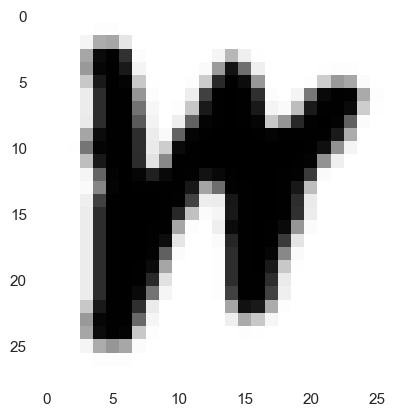

In [12]:
# Plot an image
import matplotlib.pyplot as plt
plt.grid(False)
plt.imshow(images_train[0,:,:], cmap=plt.cm.Greys);

In [13]:
labels_train[0]

23

In [14]:
import pandas as pd

df = pd.read_csv('emnist-letters-mapping.txt', header=None, sep = ' ', index_col=0)
df.columns = ['ascii', 'ascii2']
df['character'] = df['ascii'].apply(lambda x: chr(x))
df['character2'] = df['ascii2'].apply(lambda x: chr(x))
df

,ascii,ascii2,character,character2
0,,,,
1,65,97,A,a
2,66,98,B,b
3,67,99,C,c
4,68,100,D,d
5,69,101,E,e
6,70,102,F,f
7,71,103,G,g
8,72,104,H,h
9,73,105,I,i


## [ASCII Table](https://www.asciitable.com/)
<img src='https://www.asciitable.com/asciifull.gif' />

In [15]:
chr(48)

'0'

In [16]:
labels_train[0], df.iloc[labels_train[0]]

(23,
 ascii          88
 ascii2        120
 character       X
 character2      x
 Name: 24, dtype: object)

In [17]:
# 調整 y class -= 1
labels_train = labels_train - 1
labels_test = labels_test - 1
labels_train[0], df.iloc[labels_train[0]]

(22,
 ascii          87
 ascii2        119
 character       W
 character2      w
 Name: 23, dtype: object)

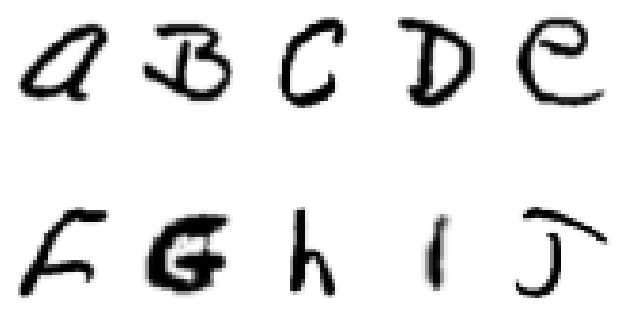

In [18]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(10):
    img = images_train[labels_train == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

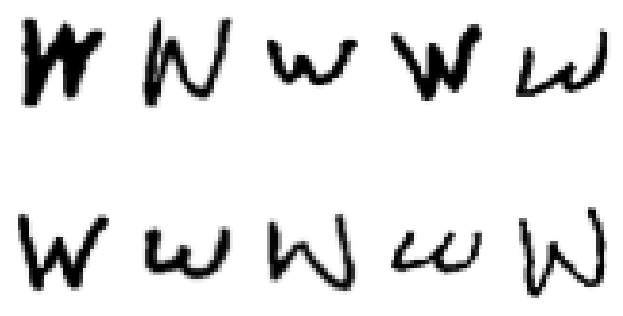

In [19]:
no=22
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(10):
    img = images_train[labels_train == no][i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

## 步驟2：資料清理，此步驟無需進行

## 步驟3：進行特徵工程，將特徵縮放成(0, 1)之間

In [20]:
# 特徵縮放，使用常態化(Normalization)，公式 = (x - min) / (max - min)
# 顏色範圍：0~255，所以，公式簡化為 x / 255
# 注意，顏色0為白色，與RGB顏色不同，(0,0,0) 為黑色。
x_train_norm, x_test_norm = images_train / 255.0, images_test / 255.0
x_train_norm = x_train_norm.reshape(x_train_norm.shape[0], 28, 28, 1)   # 增加一維
x_test_norm = x_test_norm.reshape(x_test_norm.shape[0], 28, 28, 1)      # 增加一維

## 步驟4：資料分割，此步驟無需進行，載入MNIST資料時，已經切割好了

## 步驟5：建立模型結構

In [21]:
# 建立模型
from keras.layers import Conv2D, MaxPooling2D
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(16, (3, 3),input_shape=(28, 28, 1), activation='relu'),
  tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),                # (A)
  tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),                # (B)    

  tf.keras.layers.Flatten(input_shape=(28, 28)),  # flatten 壓成一維
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(26, activation='softmax') # 0-25 共26個字母（答案）
])

資料增補 - 對於圖像數據做變形及偏移調整處理 

In [22]:
# 資料增補 Data Augmentation
# 將原來的圖片變大變小、偏一邊或旋轉
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=10,          # 旋轉
        zoom_range=0.1,             # 變更大小
        width_shift_range=0.1,      # 寬度偏移
        height_shift_range=0.1)     # 高度偏移

In [23]:
# 設定優化器(optimizer)、損失函數(loss)、效能衡量指標(metrics)的類別
model.compile(optimizer='adam',                         # adam 動態調整學習率
              loss='sparse_categorical_crossentropy',   # 分類使用交叉熵
              metrics=['accuracy'])

## 步驟6：結合訓練資料及模型，進行模型訓練

In [24]:
# 模型訓練
# callback: https://ithelp.ithome.com.tw/articles/10234641
# 自訂 callback: https://ithelp.ithome.com.tw/articles/10235293
# history = model.fit(x_train_norm, labels_train, epochs=10, validation_split=0.2)
# history = model.fit(x_train_norm, y_train, epochs=5, validation_split=0.2, batch_size= 1000)
datagen.fit(x_train_norm)
history = model.fit(datagen.flow(x_train_norm, labels_train, batch_size=640), epochs=20,
                                validation_data=datagen.flow(x_test_norm, labels_test, batch_size=640), verbose=2,
                                steps_per_epoch=x_train_norm.shape[0]//640)

Epoch 1/20
195/195 - 108s - loss: 1.2552 - accuracy: 0.6240 - val_loss: 0.5404 - val_accuracy: 0.8323 - 108s/epoch - 554ms/step
Epoch 2/20
195/195 - 101s - loss: 0.5588 - accuracy: 0.8219 - val_loss: 0.3900 - val_accuracy: 0.8756 - 101s/epoch - 517ms/step
Epoch 3/20
195/195 - 96s - loss: 0.4465 - accuracy: 0.8569 - val_loss: 0.3298 - val_accuracy: 0.8942 - 96s/epoch - 494ms/step
Epoch 4/20
195/195 - 97s - loss: 0.3872 - accuracy: 0.8756 - val_loss: 0.2959 - val_accuracy: 0.9043 - 97s/epoch - 500ms/step
Epoch 5/20
195/195 - 96s - loss: 0.3538 - accuracy: 0.8853 - val_loss: 0.2843 - val_accuracy: 0.9079 - 96s/epoch - 491ms/step
Epoch 6/20
195/195 - 95s - loss: 0.3263 - accuracy: 0.8928 - val_loss: 0.2646 - val_accuracy: 0.9137 - 95s/epoch - 485ms/step
Epoch 7/20
195/195 - 92s - loss: 0.3070 - accuracy: 0.8997 - val_loss: 0.2547 - val_accuracy: 0.9163 - 92s/epoch - 474ms/step
Epoch 8/20
195/195 - 93s - loss: 0.2903 - accuracy: 0.9054 - val_loss: 0.2516 - val_accuracy: 0.9200 - 93s/epoch -

In [25]:
# 檢查 history 所有鍵值
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

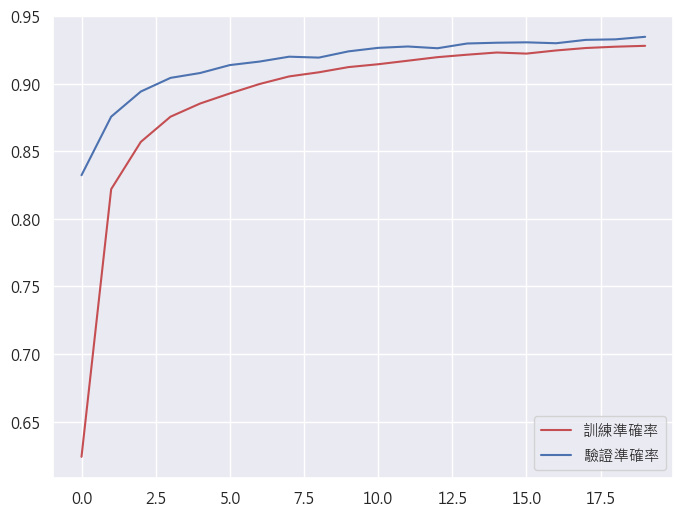

In [26]:
# 對訓練過程的準確率繪圖
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], 'r', label='訓練準確率')
plt.plot(history.history['val_accuracy'], 'b', label='驗證準確率')
plt.legend()
plt.show()

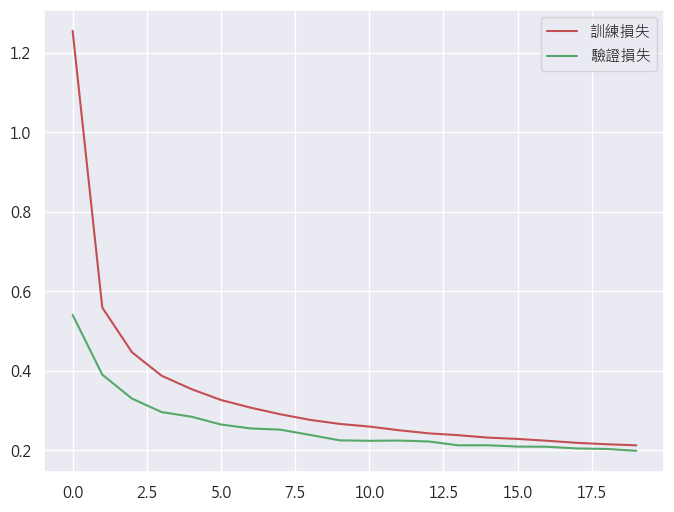

In [27]:
# 對訓練過程的損失繪圖
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], 'r', label='訓練損失')
plt.plot(history.history['val_loss'], 'g', label='驗證損失')
plt.legend()
plt.show()

## 步驟7：評分(Score Model)

In [28]:
# 評分(Score Model)
score=model.evaluate(x_test_norm, labels_test, verbose=0)

for i, x in enumerate(score):
    print(f'{model.metrics_names[i]}: {score[i]:.4f}')

loss: 0.1622
accuracy: 0.9461


In [29]:
# 實際預測 20 筆資料
# predictions = model.predict_classes(x_test_norm)
import numpy as np
predictions = np.argmax(model.predict(x_test_norm), axis=-1)

# 比對
print('actual    :', labels_test[900:920])
print('prediction:', predictions[900:920])

650/650 [==============================] - 5s 8ms/step
actual    : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
prediction: [ 1  1  1  1  1  1 17  1  1  6  1  1  1  1  1  1  1  1  1  1]


In [30]:
import numpy as np

predictions = model.predict(x_test_norm[906:907])
print(f'a~z預測機率: {np.around(predictions, 2)}')

1/1 [==============================] - 0s 83ms/step
a~z預測機率: [[0.02 0.02 0.   0.   0.   0.   0.01 0.09 0.   0.   0.02 0.24 0.01 0.11
  0.   0.   0.   0.44 0.   0.   0.01 0.   0.   0.01 0.   0.01]]


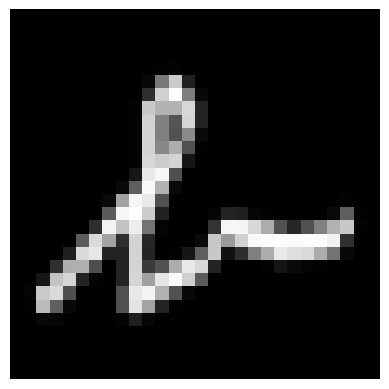

In [31]:
# 顯示第 6 筆圖像
X2 = images_test[906,:,:]
plt.imshow(X2.reshape(28,28), cmap='gray')
plt.axis('off')
plt.show() 

## 步驟8：評估，暫不進行

## 步驟9：模型佈署

In [32]:
# 模型存檔
# model.save('Emnist_model.h5')
model.save("Emnist_model.keras")
# 模型載入
model = tf.keras.models.load_model('Emnist_model.keras')
# loaded_model = keras_core.saving.load_model("model.keras")

## 步驟10：新資料預測

In [33]:
# 使用小畫家，繪製 0~9，實際測試看看
from skimage import io
from skimage.transform import resize
import numpy as np

# 讀取影像並轉為單色
uploaded_file = './test_data/d.png'
image1 = io.imread(uploaded_file, as_gray=True)
print(image1.shape)

# 縮為 (28, 28) 大小的影像
image_resized = resize(image1, (28, 28), anti_aliasing=True)    
X1 = image_resized.reshape(1,28, 28) #/ 255 skimage 已經做了縮放過

# 反轉顏色，顏色0為白色，與 RGB 色碼不同，它的 0 為黑色
X1 = np.abs(1-X1)

# 預測
#predictions = model.predict_classes(X1)
predictions = np.argmax(model.predict(X1), axis=-1) # argmax 找出最大值所在的索引值在哪
print(predictions[0])
print(chr(predictions[0]+65))

(280, 280)
1/1 [==============================] - 0s 88ms/step
3
D


In [34]:
model.predict(X1)

1/1 [==============================] - 0s 32ms/step


array([[6.0404656e-03, 4.0747292e-04, 5.0489639e-04, 9.7778261e-01,
        8.3828613e-04, 4.9113459e-04, 5.8635097e-04, 9.0899346e-05,
        5.1322021e-04, 1.5068889e-03, 2.9434441e-05, 4.1549494e-03,
        1.4488906e-05, 6.0780836e-05, 5.5327069e-05, 1.8359870e-05,
        6.0000579e-04, 3.3539935e-05, 6.0934608e-06, 5.2664527e-03,
        5.9547077e-04, 1.1850225e-05, 4.1148792e-06, 3.3086681e-04,
        4.7177164e-05, 8.8042734e-06]], dtype=float32)

In [35]:
np.sum(model.predict(X1))

1/1 [==============================] - 0s 57ms/step


0.99999994

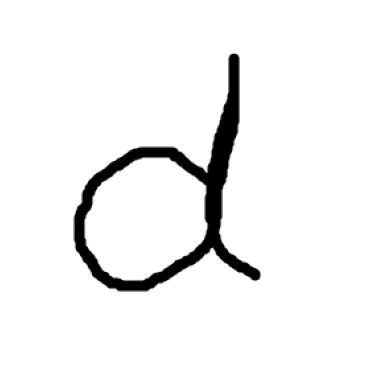

In [36]:
# 繪製點陣圖，cmap='gray':灰階
plt.imshow(image1, cmap='gray')

# 隱藏刻度
plt.axis('off') 

# 顯示圖形
plt.show() 

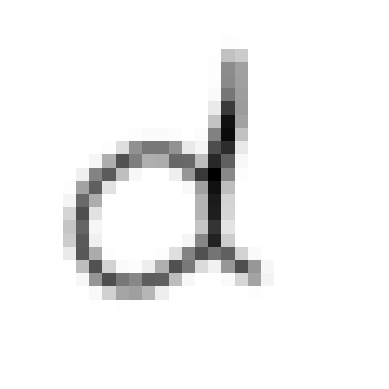

In [37]:
# 繪製點陣圖，cmap='gray':灰階
plt.imshow(image_resized, cmap='gray')

# 隱藏刻度
plt.axis('off') 

# 顯示圖形
plt.show() 

In [38]:
import os
for dirname, _, filenames in os.walk('./test_data'):
    for filename in filenames:
        uploaded_file = os.path.join(dirname, filename)
        image1 = io.imread(uploaded_file, as_gray=True)

        # 縮為 (28, 28) 大小的影像
        image_resized = resize(image1, (28, 28), anti_aliasing=True)    
        X1 = image_resized.reshape(1,28, 28) #/ 255

        # 反轉顏色，顏色0為白色，與 RGB 色碼不同，它的 0 為黑色
        X1 = np.abs(1-X1)

        # 預測
        predictions = np.argmax(model.predict(X1), axis=-1)
        print(chr(predictions[0]+65))

1/1 [==============================] - 0s 31ms/step
A
1/1 [==============================] - 0s 30ms/step
B
1/1 [==============================] - 0s 31ms/step
C
1/1 [==============================] - 0s 30ms/step
D
1/1 [==============================] - 0s 34ms/step
E
1/1 [==============================] - 0s 25ms/step
F
1/1 [==============================] - 0s 26ms/step
G
1/1 [==============================] - 0s 26ms/step
H
1/1 [==============================] - 0s 24ms/step
I
1/1 [==============================] - 0s 25ms/step
J
1/1 [==============================] - 0s 27ms/step
K
1/1 [==============================] - 0s 25ms/step
O


## 其他：顯示模型彙總資訊(summary)、繪製圖形顯示模型結構

In [39]:
# 顯示模型的彙總資訊
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        4640      
                                                                 
 max_pooling2d (MaxPooling2  (None, 12, 12, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 1600)              0

In [40]:
import pandas as pd 
predictions = np.argmax(model.predict(x_test_norm), axis=-1)
pd.crosstab(labels_test, predictions, rownames=['實際值'], colnames=['預測值'])

650/650 [==============================] - 6s 9ms/step


預測值,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
實際值,,,,,,,,,,,,,,,,,,,,,
0,774,0,1,4,0,2,4,3,0,1,...,5,0,0,0,2,0,0,0,0,2
1,0,782,0,1,1,0,2,5,0,0,...,1,3,0,0,1,0,0,0,0,2
2,0,0,778,1,3,0,0,0,0,0,...,1,2,0,1,3,0,0,0,0,2
3,3,0,0,777,0,1,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,3,0,9,0,774,3,1,0,1,0,...,0,1,0,0,1,0,0,0,0,1
5,0,1,0,0,2,775,2,0,0,0,...,0,1,0,16,0,0,0,0,0,0
6,14,5,4,0,0,2,688,0,0,0,...,79,0,3,0,0,0,0,0,2,0
7,1,2,0,1,0,0,0,769,0,0,...,0,0,0,1,0,0,0,1,0,0
8,0,0,1,1,1,1,0,0,573,13,...,0,1,0,0,0,1,0,0,0,1
